In [1]:
import warnings

warnings.filterwarnings("ignore")

import torch
import os
import yaml
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from utils.utils_nucleus import *
from utils.PGA import PGA

print("cuda available? ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

cuda available?  True


In [2]:
hemato_1 = (73, 119, 185.0)
eosin = (245, 143.0, 204)
safran = (248.0, 245, 152)
hemato_2 = (123, 153, 198)
Wgt = -np.log(np.array([hemato_1, eosin, safran, hemato_2]).T / 255)
pga = PGA(Wgt, device=device)
Lambda = 1.15e-1
poids = (1.5, 1)

In [3]:
slide_name = "64A"
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

vis_scale = config["patching"]["vis_scale"]
tumor_checkpoints = "../" + config["paths"]["pth_to_tumor_ckpts"]
patches_bis_path = "../" + config["paths"]["pth_to_patches"].replace(
    "patches", "patches_bis"
)
Path(f"../data/patches_He/{slide_name}").mkdir(exist_ok=True)
print(patches_bis_path)
chkpt_tumor = torch.load(f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt")
chkpt_coords = torch.load(
    f"../checkpoints/coords_checkpoints/{slide_name}_coords_checkpoint.pt"
)

../data/patches_bis/


FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/tumor_checkpoints/64A_preds_probas_checkpoint.pt'

In [ ]:
y_har_preds = chkpt_tumor["har_mean_preds"]

In [ ]:
coords_x, coords_y = [], []
for patch in os.listdir(f"{patches_bis_path}/{slide_name}"):
    _, _, x, _, y = patch[:-4].split("_")
    coords_x.append(int(x))
    coords_y.append(int(y))

In [ ]:
model = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke", batch_size=256
)

|2026-02-22|12:00:52.382| [WARNING] torch-compile is currently not supported in Python 3.12+.


In [ ]:
y_harmonic = y_har_preds.numpy()
images = []
for j in tqdm(range(len(y_har_preds)), desc="load images and gen Hematoxylin"):
    x, y, p = coords_x[j], coords_y[j], y_harmonic[j]
    if p != 0:
        try:
            patch = f"patch_x_{x}_y_{y}.jpg"
            im = plt.imread(f"{patches_bis_path}{slide_name}/{patch}")
            V = vectorize(im)
            N, M, _ = im.shape
            H0 = np.maximum((pinv(Wgt) @ V), 0)

            im_He = getHstain(V, Wgt, H0, Lambda, pga, poids, n=im.shape[0])
            plt.imsave(
                f"../data/patches_He/{slide_name}/{patch.replace('.', '_He.')}", im_He
            )
            images.append(
                f"../data/patches_He/{slide_name}/{patch.replace('.', '_He.')}"
            )
        except Exception as e:
            print(f"Error in {x} {y}: {e}")
            continue

save_dir = "../checkpoints/nucleus_dats"
images.sort()
tile_output = model.predict(
    images,
    mode="tile",
    save_dir=save_dir + f"/{slide_name}",
    device=device,
    crash_on_exception=True,
)
print(f"Done! {slide_name}, {len(tile_output)}")

100%|██████████| 1553/1553 [13:53<00:00,  1.86it/s]

Done! 222A, 1553


In [ ]:
# defining the coloring dictionary: a dictionary that specifies a color to each class {type_id : (type_name, colour)}
color_dict = {
    0: ("neoplastic epithelial", (0, 0, 0)),
    1: ("Inflammatory", (0, 0, 0)),
    2: ("Connective", (0, 0, 0)),
    3: ("Dead", (0, 0, 0)),
    4: ("non-neoplastic epithelial", (0, 0, 0)),
    5: ("  ", (0, 0, 0)),
}

Number of detected nuclei: 186


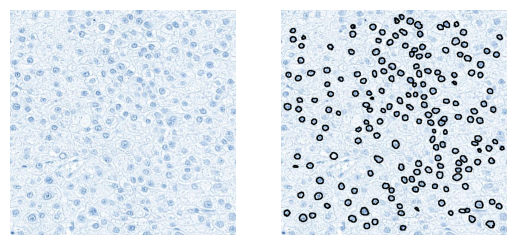

In [ ]:
import joblib
from tiatoolbox.utils.visualization import overlay_prediction_contours

idx = 150
tile_preds = joblib.load(f"{tile_output[idx][1]}.dat")
print("Number of detected nuclei: {}".format(len(tile_preds)))

# Create the overlay image
overlaid_predictions = overlay_prediction_contours(
    canvas=plt.imread(tile_output[idx][0]),
    inst_dict=tile_preds,
    draw_dot=False,
    type_colours=color_dict,
    line_thickness=2,
)

# showing processed results alongside the original images
fig = plt.figure()
ax1 = plt.subplot(1, 2, 1), plt.imshow(plt.imread(tile_output[idx][0])), plt.axis("off")
ax2 = plt.subplot(1, 2, 2), plt.imshow(overlaid_predictions), plt.axis("off")

In [ ]:
def get_contours(
    inst_dict: dict, inst_colours: np.ndarray | tuple[int, int, int] = (255, 255, 0)
):
    if inst_colours is None:
        inst_colours = random_colors(len(inst_dict), bright=True)

    if not isinstance(inst_colours, (tuple, np.ndarray)):
        msg = f"`inst_colours` must be np.ndarray or tuple: {type(inst_colours)}."
        raise TypeError(
            msg,
        )

    inst_colours_array = np.array(inst_colours) * 255

    if isinstance(inst_colours, tuple):
        inst_colours_array = np.array([inst_colours] * len(inst_dict))

    inst_colours_array = inst_colours_array.astype(np.uint8)
    contours = []
    for _, [_, inst_info] in enumerate(inst_dict.items()):
        inst_contour = inst_info["contour"]
        contours.append(np.array(inst_contour))
    return contours

In [ ]:
all_x, all_y, median_areas, mean_areas, nucleocytos, densities, anisos, median_vars = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)
for i in tqdm(range(len(tile_output))):
    try:
        tile_preds = joblib.load(f"{tile_output[i][1]}.dat")
        im = plt.imread(tile_output[i][0])
        contours = get_contours(inst_dict=tile_preds)
        final_im = segmentNucleus(im, contours)
        density, mean_area, median_area, aniso, _, nucyto_idx = computeFeatures(
            contours, final_im
        )
        _, _, x, _, y, _ = str(tile_output[i][0]).split("/")[-1].split("_")
        all_x.append(int(x))
        all_y.append(int(y))
        densities.append(density)
        mean_areas.append(mean_area)
        median_areas.append(median_area)
        anisos.append(aniso)
        nucleocytos.append(nucyto_idx)
    except Exception as e:
        print(f"Error in {str(tile_output[i][0])}: {e}")
        continue

100%|██████████| 1553/1553 [01:40<00:00, 15.51it/s]


In [ ]:
scaled_slide = chkpt_tumor["scaled_slide"]
[x_start, y_start, x_end, y_end] = chkpt_coords["xy_start_end"]
[real_x, real_y, real_w, real_h] = chkpt_coords["xywh_real"]
width, height = int(real_w * vis_scale), int(real_h * vis_scale)
coords_x = np.array(coords_x) * vis_scale - x_start
coords_y = np.array(coords_y) * vis_scale - y_start

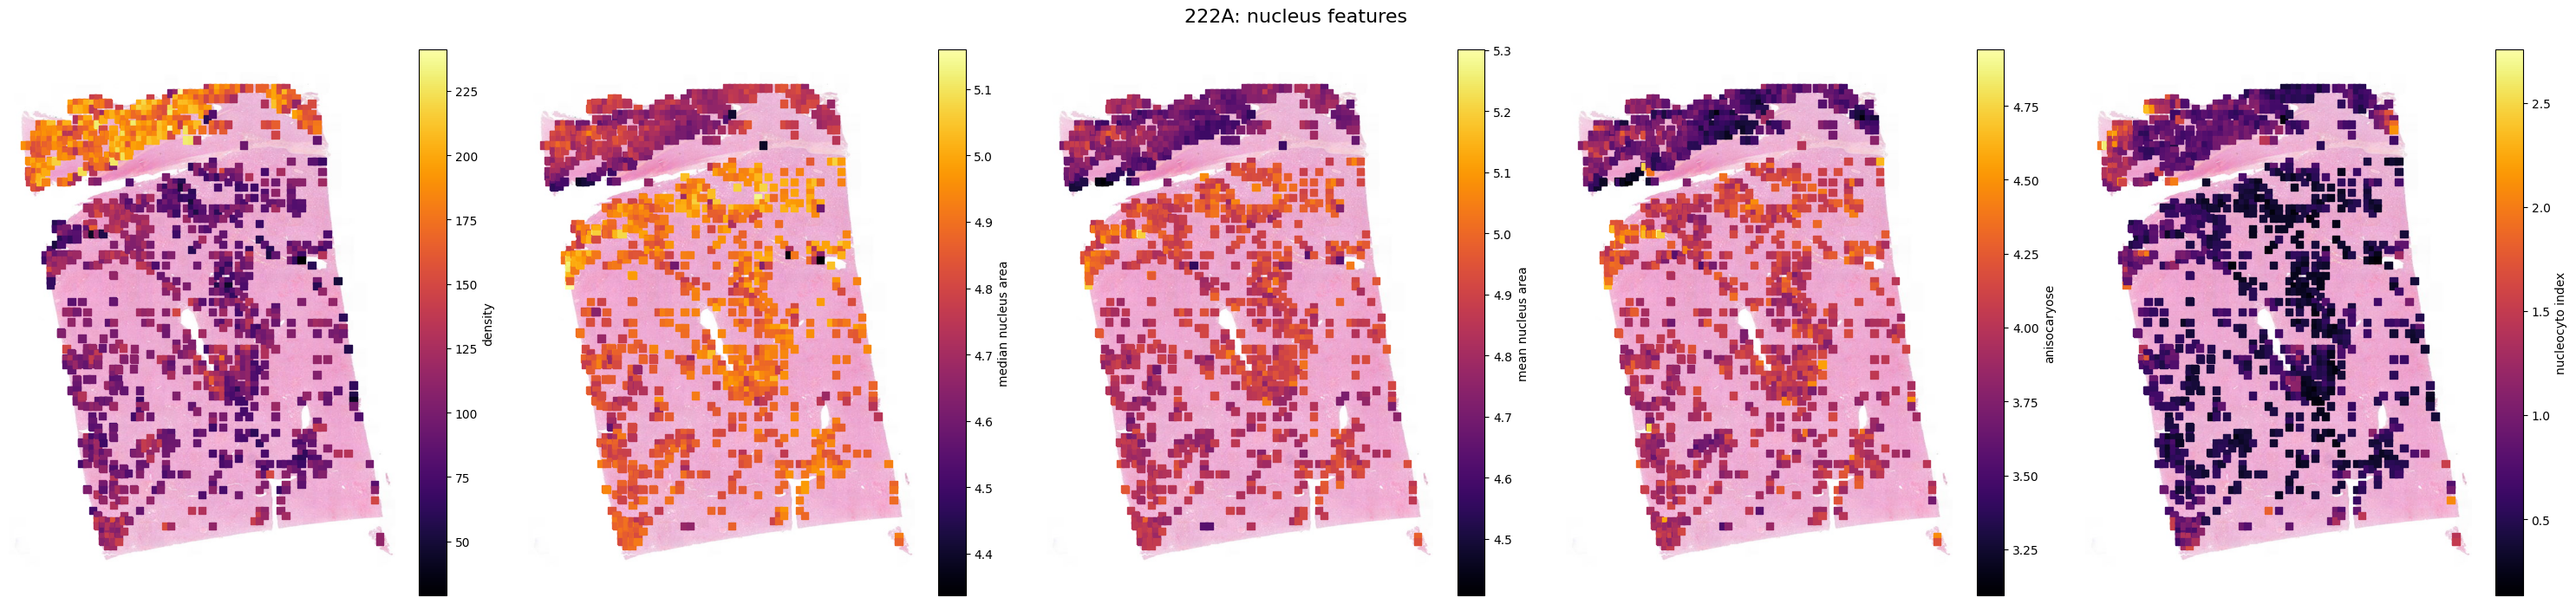

In [ ]:
df_features = pd.DataFrame(
    {
        "x": all_x,
        "y": all_y,
        "density": densities,
        "median nucleus area": median_areas,
        "mean nucleus area": mean_areas,
        "anisocaryose": anisos,
        "nucleocyto index": nucleocytos,
    }
)
df_features.to_csv(
    f"../checkpoints/nucleus_checkpoints/{slide_name}_nucleus_features.csv", index=False
)
cx, cy = (
    np.array(df_features["x"]) * vis_scale - x_start,
    np.array(df_features["y"]) * vis_scale - y_start,
)
feature_keys = [
    "density",
    "median nucleus area",
    "mean nucleus area",
    "anisocaryose",
    "nucleocyto index",
]

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(30, 7))
fig.suptitle(slide_name + ": nucleus features", fontsize=16, y=0.99)
axes = axes.flatten()
for ax, key in zip(axes, feature_keys):
    values = (
        np.log1p(df_features[key])
        if "area" in key or "variance" in key or "anisocaryose" in key
        else df_features[key]
    )
    ax.imshow(scaled_slide)
    scatter = ax.scatter(cx, cy, c=values, cmap="inferno", marker="s")
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(key)
    ax.axis("off")
plt.tight_layout()
plt.show()